In [359]:
import os, string

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation
from shapely.ops import cascaded_union
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'
path_to_input     = '/Users/Guille/Desktop/india_power/input_data_2022/'
path_to_data      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/data/'
path_to_load      = '/Users/Guille/Desktop/india_power/input_data_2022/load'

In [360]:
def _load_system_demand_scenarios(scens_, scen_labels_, path):

    dfs_ = []
    for scen, scen_label in zip(scens_, scen_labels_):
        df_             = pd.read_csv(path + '/' + scen + '/Demandhourly2020-2050-India.csv')
        df_['scenario'] = scen_label
        dfs_           += [df_]
          
    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

def _plot_monthly_demand_comparison(ax_, df_, scen_labels_, fys_, i_month, 
                                    legend = True,     
                                    ylabel = 'Demand (GWh)',
                                    xlabel = 'Time (hh:mm)'):
    
    months_ = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    ls_ = ['dotted', 'dashed', 'dashdot', 'solid']

    x_ = np.linspace(0, 23, 24)

    colors_ = ['#136564', '#2cb7b5', '#756a01', '#ca8250', '#d8a581']
    ls_    = ['dashed', 'solid']

    for fy, j in zip(fys_, range(len(fys_))):
        for scen_label, k in zip(scen_labels_, range(len(scen_labels_))):

            idx_  = (df_['FY'] == fy) & (df_['Month'] == i_month + 1) & (df_['scenario'] == scen_label)
            df_p_ = df_.loc[idx_, ['Day', 'Interval', 'India']].reset_index(drop = True)

            df_pp_ = np.concatenate([df_p_.loc[df_p_['Day'] == d, 'India'].reset_index(drop = True).to_numpy()[:, np.newaxis] 
                                     for d in np.sort(df_p_['Day'].unique())], axis = 1)

            if method == 'avg': y_ = np.mean(df_pp_, axis = 1)
            if method == 'max': y_ = df_pp_[:, np.max(df_pp_, axis = 0).argmax()]
            if method == 'min': y_ = df_pp_[:, np.min(df_pp_, axis = 0).argmin()]

            if (fy == 2020) & (scen_label == r'Linearly-scaled Demand'):
                ax_.plot(x_, y_/1e3, 
                         c     = '#92918b', 
                         label = '2020 Historical Demand',
                         ls    = 'solid',
                         lw    = 2.5,
                         alpha = 0.75)
                continue
                
            if (fy == 2020) & (scen_label == r'Bottom-up Modified Demand'):
                continue
                
            ax_.plot(x_, y_/1e3, 
                     c     = colors_[k], 
                     label = '2050 ' + scen_label,
                     ls    = 'solid',
                     lw    = 2.5,
                     alpha = 0.75)
    
    if legend:
        ax_.legend(loc = (1.05, .35),
                   frameon = False,
                   handlelength   = 1.75,
                   ncol    = 1,
                   prop    = {'size': 12})
    
    ax_.set_ylabel(ylabel, fontsize = 16)
    ax_.set_xlabel(xlabel, fontsize = 16)

    #ax_.set_xticks(x_[::4], ["%02d:00" % x for x in x_][::4], rotation = 90)
    ax_.set_xticks([0, 12, 23], ['00:00', '12:00', '23:00'], rotation = 0)

    ax_.xaxis.set_tick_params(labelsize = 12)
    ax_.yaxis.set_tick_params(labelsize = 12, left = False)

    ax_.set_xlim(0, 23)
    ax_.set_ylim(-5, 1000)

    ax_.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax_.set_title(months_[i_month], fontsize = 18)

    ax_.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax_.grid(axis = 'y')
    
    ax_.axhline(0, linewidth = 1., 
                   linestyle = '-', 
                   color     = 'k', 
                   clip_on   = False, 
                   zorder    = 10)


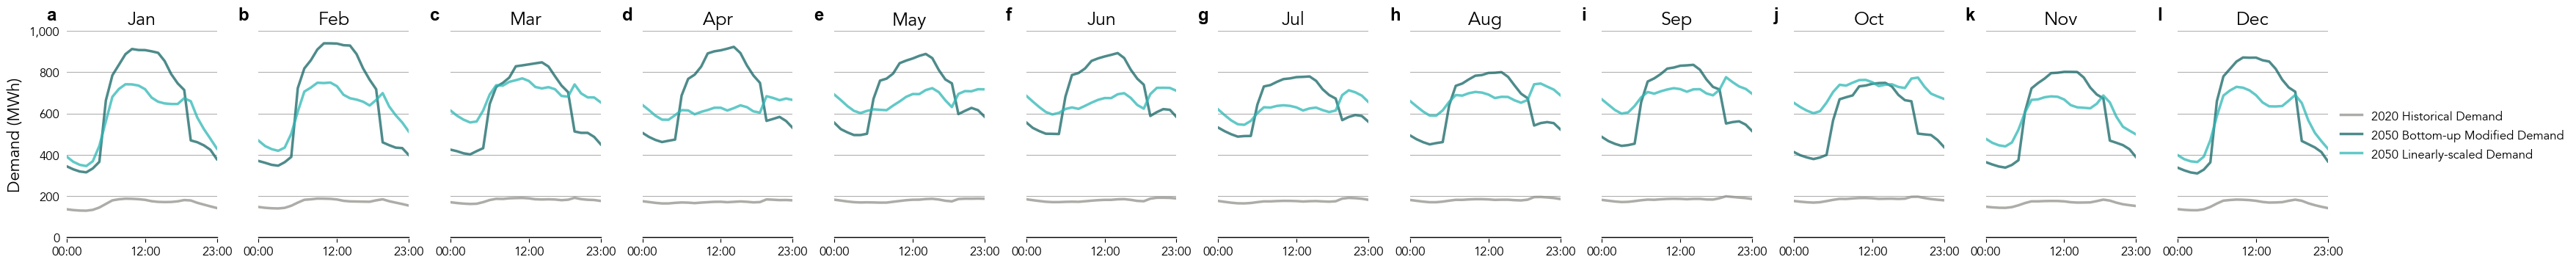

In [3]:
method = 'avg'

scen_labels_ = [r'Bottom-up Modified Demand', 
                r'Linearly-scaled Demand']

scens_ = ['2050-demand_forecast-transmission-PIERv2_2019_mid',
          '2050-demand_forecast-transmission-ICED_2019_mid']

fys_   = [2020, 2050]

    
df_ = _load_system_demand_scenarios(scens_, scen_labels_, path_to_load)

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']],
                              layout      = 'constrained', 
                              figsize     = (35, 3.5), 
                              sharey      = True,
                              gridspec_kw = {'width_ratios': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans),
            fontsize  = 'xx-large', 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')
    
_plot_monthly_demand_comparison(_ax['a'], df_, scen_labels_, fys_, 0, ylabel = 'Demand (MWh)', xlabel = '', legend = False)
_plot_monthly_demand_comparison(_ax['b'], df_, scen_labels_, fys_, 1, ylabel = '', xlabel = '', legend = False)
_plot_monthly_demand_comparison(_ax['c'], df_, scen_labels_, fys_, 2, ylabel = '', xlabel = '', legend = False)
_plot_monthly_demand_comparison(_ax['d'], df_, scen_labels_, fys_, 3, ylabel = '', xlabel = '', legend = False)
_plot_monthly_demand_comparison(_ax['e'], df_, scen_labels_, fys_, 4, ylabel = '', xlabel = '', legend = False)
_plot_monthly_demand_comparison(_ax['f'], df_, scen_labels_, fys_, 5, ylabel = '', xlabel = '', legend = False)
_plot_monthly_demand_comparison(_ax['g'], df_, scen_labels_, fys_, 6, ylabel = '', xlabel = '', legend = False)
_plot_monthly_demand_comparison(_ax['h'], df_, scen_labels_, fys_, 7, ylabel = '', xlabel = '', legend = False)
_plot_monthly_demand_comparison(_ax['i'], df_, scen_labels_, fys_, 8, ylabel = '', xlabel = '', legend = False)
_plot_monthly_demand_comparison(_ax['j'], df_, scen_labels_, fys_, 9, ylabel = '', xlabel = '', legend = False)
_plot_monthly_demand_comparison(_ax['k'], df_, scen_labels_, fys_, 10, ylabel = '', xlabel = '', legend = False)
_plot_monthly_demand_comparison(_ax['l'], df_, scen_labels_, fys_, 11, ylabel = '', xlabel = '', legend = True)

# plt.savefig(path_to_images + f'/demand_profiles-{method}.pdf', 
#             bbox_inches = 'tight', 
#             dpi         = 600)

plt.savefig(path_to_images + f'/demand_profiles-{method}.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [4]:
def _load_system_demand_scenarios(scenario, path):

    dfs_ = []
    for file in os.listdir(path + "/" + scenario):
        if file.endswith(".csv"):
            #print(file)
            dfs_ += [pd.read_csv(path + '/' + scenario + '/' + file)]

    df_ = dfs_[0]
    for i in range(len(dfs_) - 1):
        df_ = df_.merge(dfs_[i + 1], on = ['FY', 'Month', 'Day', 'Interval', 'Year'])

    df_ = df_.drop(columns = ['Bhutan', 'India'])
    return df_


tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv')

df_ = _load_system_demand_scenarios(scenario = '2050-demand_forecast-transmission-ICED_2019_mid', 
                                    path     = path_to_load)
print(df_)

          FY  Month  Day  Interval  Year  Uttar_Pradesh    Daman_Diu  \
0       2020      4    1         0  2019   15451.499755   358.069884   
1       2020      4    1         1  2019   14998.836239   347.860385   
2       2020      4    1         2  2019   14879.521446   338.623219   
3       2020      4    1         3  2019   14626.683271   333.761553   
4       2020      4    1         4  2019   14612.086783   333.761553   
...      ...    ...  ...       ...   ...            ...          ...   
271555  2050      3   31        19  2050   79961.531596  1314.905017   
271556  2050      3   31        20  2050   82800.352579  1160.915874   
271557  2050      3   31        21  2050   80791.182694  1166.726785   
271558  2050      3   31        22  2050   75685.468552  1166.726785   
271559  2050      3   31        23  2050   71276.591061  1160.915874   

        Himachal_Pradesh   Puducherry      Sikkim  ...  Chandigarh  \
0             943.600934   348.066553   39.762782  ...  148.80906

In [5]:
df_p_   = df_.loc[df_['FY'] == 2020].copy()
df_p_   = df_p_[df_p_.columns[5:]].T
demand_ = pd.DataFrame(np.vstack([np.sum(df_p_.to_numpy(), axis = 1), 
                                  df_p_.index.values]).T, columns = ['load_mw', 'state'])
print(demand_)

             load_mw               state
0   133352716.643796       Uttar_Pradesh
1     3404354.950665           Daman_Diu
2    10761795.722244    Himachal_Pradesh
3     3045309.363199          Puducherry
4      488250.529912              Sikkim
5      339825.448852            Nagaland
6    82781945.684012           Karnataka
7   172817872.030009         Maharashtra
8      252003.237922             Mizoram
9    35319488.810854               Bihar
10     559942.242342             Tripura
11   48506598.892496        Chhattisgarh
12   64016799.145217              Punjab
13  117410732.787581          Tamil_Nadu
14   77639433.959964      Madhya_Pradesh
15   72859691.242186         West_Bengal
16   35073616.523851           Jharkhand
17      692069.88323             Manipur
18   95451299.935789           Rajasthan
19  152977580.240554             Gujarat
20   36888144.611032               Delhi
21   31198308.450224              Kerala
22    1309660.902351           Meghalaya
23   14144023.24

In [6]:
gen_ = pd.read_csv(path_to_data + "india_gen_2019-20.csv")
idx_ = gen_['state'] == 'Andaman and Nicobar Islands'
gen_ = gen_.loc[~idx_].reset_index(drop = True)

gen_.loc[gen_['source'] == 'Oil & Gas', 'source']   = 'Gas'
gen_.loc[gen_['source'] == 'Bio Power', 'source']   = 'Other'
gen_.loc[gen_['source'] == 'Small Hydro', 'source'] = 'Hydro'

gen_['type'] = 'clean'

gen_.loc[gen_['source'].isin(['Coal', 'Gas', 'Diesel', 'Nuclear']), 'type'] = 'no_clean'

gen_ = gen_[['state', 'source', 'type', 'generation_gwh']]
gen_ = gen_.groupby(['state', 'source', 'type', 'generation_gwh']).agg('sum').reset_index(drop = False)

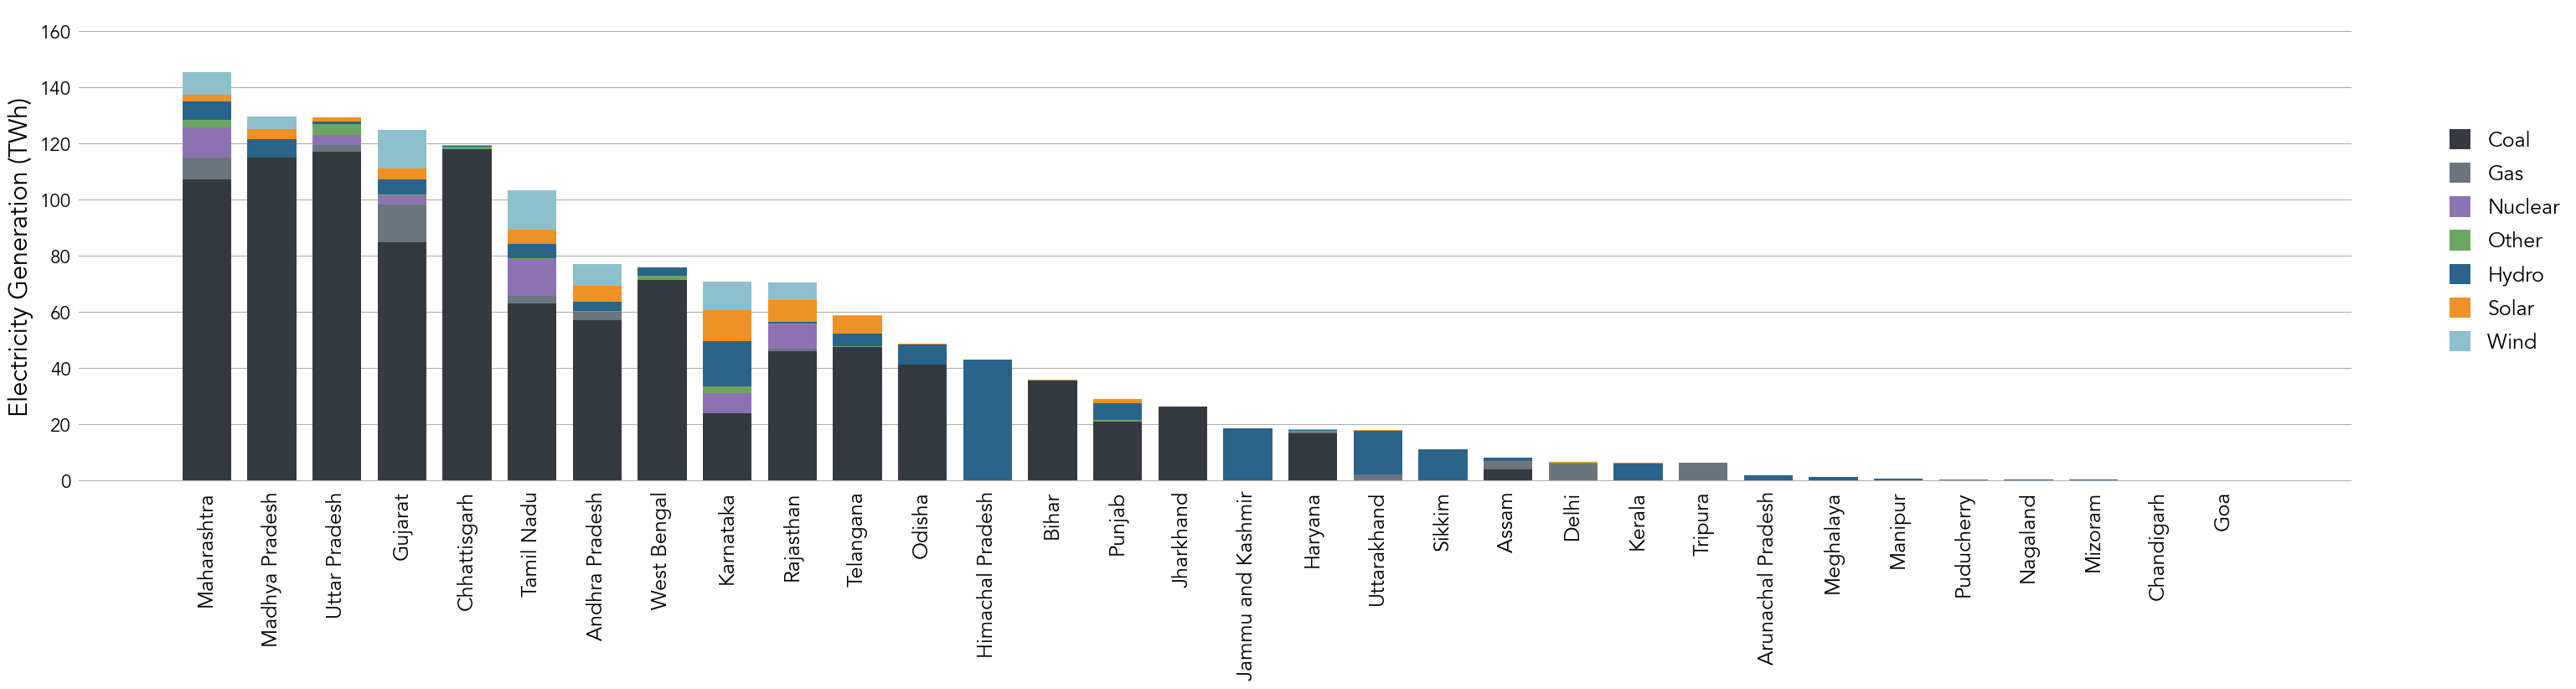

In [7]:
def _plot_dispatch_by_zone(ax, df_1_, df_2_, tech_label_,
                           units       = 1e3,
                           y_lim_min   = - 10,
                           y_lim_max   = 10,
                           ylabel      = r'Electricity Generation (TWh)',
                           legend      = True,
                           title       = ''):

    def __make_dispatch_legend(ax, df_, techs_):
        
        tech_idx_ = np.sort(np.unique(techs_['order']))

        for i_tech in tech_idx_:
            tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
            color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
            
            idx_ = df_['source'] == tech
            
            if idx_.sum() > 0:
                if df_.loc[idx_, 'generation_gwh'].to_numpy().sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = color,
                                       label  = tech.replace('_', ' '),
                                       zorder = 2,
                                       ec     = 'None',
                                       lw     = 0.,
                                       aa     = True)

    tech_idx_ = np.sort(np.unique(tech_label_['order']))

    total_ = df_1_.groupby(['state']).agg('sum').reset_index(drop = False).sort_values('generation_gwh', ascending = False)
    #total_ = df_1_.loc[df_1_['type']== 'clean'].groupby(['state']).agg('sum').reset_index(drop = False).sort_values('generation_gwh', ascending = False)
    #print(total_)
    total_ = total_.loc[total_['generation_gwh'] > 0.].reset_index(drop = True)
        
    zones_ = total_['state'].to_numpy()

    width = 0.75
    x_    = np.linspace(0, len(zones_) - 1, len(zones_))

    ticks_    = []
    labels_   = []
    x_period_ = []
    y_period_ = []
    
    i_scen          = 0
    offset_positive = 0.
    offset_negative = 0.    
    y_max           = 0
    y_min           = 0
    
    gen = 0.
    demand = 0.

    __make_dispatch_legend(ax, df_1_, tech_label_)
    
    for zone, i_zone in zip(zones_, range(len(zones_))):

        for i_tech in tech_idx_:
            tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
            color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
            
            idx_ = (df_1_['state'] == zone) & (df_1_['source'] == tech)

            if (idx_.sum() > 0):
                power = df_1_.loc[idx_, 'generation_gwh'].sum()

                if power != 0:
                    if power > 0:
                        offset = offset_positive
                    else:
                        offset = offset_negative
                    gen += power/units
                    ax.bar(x_[i_zone], power/units, width, bottom = offset/units,
                                                           color  = color,
                                                           zorder = 2,
                                                           ec     = 'None',
                                                           lw     = 0.,
                                                           aa     = True)

                    if power >= 0:
                        offset_positive += power
                    else:
                        offset_negative += power

        if offset_negative/units < y_min: 
            y_min = offset_negative/units
        if offset_positive/units > y_max: 
            y_max = offset_positive/units

        idx_ = df_2_['state'] == zone.replace(' and ', ' ').replace(' ', '_')

        power = df_2_.loc[idx_, 'load_mw'].to_numpy()[0]/1e6*0.925
        demand += power
        # if i_zone == 0:
        #     ax.plot(x_[i_zone], power, marker          = 'o', 
        #                                c               = 'white', 
        #                                label           = 'Demand (TW)',
        #                                zorder          = 6,
        #                                markersize      = 10,
        #                                markeredgewidth = 2.5,
        #                                markeredgecolor = 'k', clip_on = False)
        # else:
        #     ax.plot(x_[i_zone], power, marker          = 'o', 
        #                                c               = 'white', 
        #                                zorder          = 6, 
        #                                markersize      = 10,
        #                                markeredgewidth = 2.5,
        #                                markeredgecolor = 'k', clip_on = False)
            
        ticks_.append(x_[i_zone])
        labels_.append(zone)
        x_period_.append(x_[i_zone])
        y_period_.append(offset_positive)

        offset_positive = 0.
        offset_negative = 0.

    x_ = x_ + .9/len(zones_)        

    ax.set_xticks(ticks_, [label.replace("_", " ") for label in labels_], rotation = 90)
    ax.xaxis.set_tick_params(labelsize = 18, left = False)
    ax.set_ylabel(ylabel, fontsize = 22)
    ax.yaxis.set_tick_params(labelsize = 16, left = False)
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    if legend:
        ax.legend(bbox_to_anchor = (1.1, 0.825),
                  frameon        = False,
                  prop           = {'size': 18})

    ax.set_ylim(y_lim_min, y_lim_max)

    ax.set_title(title, fontsize = 18)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')
            
fig = plt.figure(figsize = (35, 7))
_ax = plt.subplot(111)

_plot_dispatch_by_zone(_ax, gen_, demand_, tech_labels_, 
                       y_lim_min   = -1,
                       y_lim_max   = 160,
                       title       = f' ',
                       ylabel      = 'Electricity Generation (TWh)')

plt.savefig(path_to_images + f'/gen_2019-2020.png', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

In [208]:
# New projects costs and operational characteristics
new_projects_excel            = path_to_input + "new_projects_v37.xlsx"
new_battery_costs_all         = pd.read_excel(new_projects_excel, sheet_name = "adapted_new_battery_costs_2050")
new_hydrogen_cavern_costs_all = pd.read_excel(new_projects_excel, sheet_name = "new_hydrogen_cavern_costs_2050")
new_hydrogen_tank_costs_all   = pd.read_excel(new_projects_excel, sheet_name = "new_hydrogen_tank_costs_2050")
new_solar_costs_all           = pd.read_excel(new_projects_excel, sheet_name = "adapted_new_solar_costs_2050")
new_wind_costs_all            = pd.read_excel(new_projects_excel, sheet_name = "adapted_new_wind_costs_2050")
new_conventional_costs_all    = pd.read_excel(new_projects_excel, sheet_name = "new_conventional_costs_2050")
new_nuclear_costs_all         = pd.read_excel(new_projects_excel, sheet_name = "new_nuclear_costs_2050")
new_hydro_costs_all           = pd.read_excel(new_projects_excel, sheet_name = "new_hydro_pumped_costs_2050")

USD_to_INR = 72

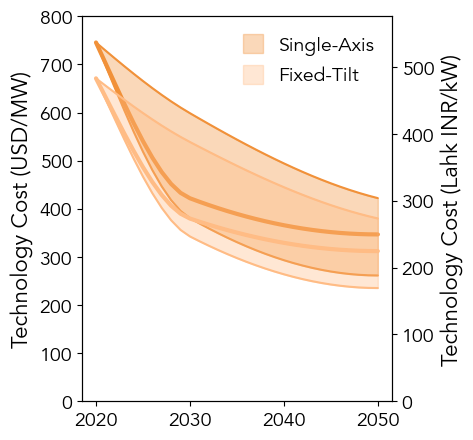

In [327]:
def _plot_solar_cost(ax, df_, 
                     ylabel = r'Technology Cost (USD/MW)',
                     yplabel = r'Technology Cost (Lahk INR/kW)'):

    idx_single_low_  = (df_['scenario'] == 'PVlow') & (df_['technology'] == 'SolarPV_single')
    idx_single_mid_  = (df_['scenario'] == 'PVmid') & (df_['technology'] == 'SolarPV_single')
    idx_single_high_ = (df_['scenario'] == 'PVhigh') & (df_['technology'] == 'SolarPV_single')

    idx_tilt_low_  = (df_['scenario'] == 'PVlow') & (df_['technology'] == 'SolarPV_tilt')
    idx_tilt_mid_  = (df_['scenario'] == 'PVmid') & (df_['technology'] == 'SolarPV_tilt')
    idx_tilt_high_ = (df_['scenario'] == 'PVhigh') & (df_['technology'] == 'SolarPV_tilt')

    idx_roof_low_  = (df_['scenario'] == 'PVlow') & (df_['technology'] == 'SolarPV_roof')
    idx_roof_mid_  = (df_['scenario'] == 'PVmid') & (df_['technology'] == 'SolarPV_roof')
    idx_roof_high_ = (df_['scenario'] == 'PVhigh') & (df_['technology'] == 'SolarPV_roof')

    ax.plot(df_.loc[idx_single_low_, 'vintage'], df_.loc[idx_single_low_, 'capital_real_cost_per_kw'],
            color = '#f19139', lw = 1.5, zorder = 1, solid_capstyle='round')
    ax.plot(df_.loc[idx_single_mid_, 'vintage'], df_.loc[idx_single_mid_, 'capital_real_cost_per_kw'],
            color = '#f19139', lw = 3, zorder = 1, solid_capstyle='round')
    ax.plot(df_.loc[idx_single_high_, 'vintage'], df_.loc[idx_single_high_, 'capital_real_cost_per_kw'],
            color = '#f19139', lw = 1.5, zorder = 1, solid_capstyle='round')

    ax.fill_between(df_.loc[idx_single_mid_, 'vintage'], 
                    df_.loc[idx_single_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_single_high_, 'capital_real_cost_per_kw'], 
                    color = '#f19139', alpha = .35, label = 'Single-Axis', zorder = 1)
    
#     ax.plot(df_.loc[idx_roof_low_, 'vintage'], df_.loc[idx_roof_low_, 'capital_real_cost_per_kw'],
#             color = '#ffbc85', lw = 1.5, zorder = 2, solid_capstyle='round')
#     ax.plot(df_.loc[idx_roof_mid_, 'vintage'], df_.loc[idx_roof_mid_, 'capital_real_cost_per_kw'],
#             color = '#ffbc85', lw = 3, zorder = 2, solid_capstyle='round')
#     ax.plot(df_.loc[idx_roof_high_, 'vintage'], df_.loc[idx_roof_high_, 'capital_real_cost_per_kw'],
#             color = '#ffbc85', lw = 1.5, zorder = 2, solid_capstyle='round')
    
#     ax.fill_between(df_.loc[idx_roof_mid_, 'vintage'], 
#                     df_.loc[idx_roof_low_, 'capital_real_cost_per_kw'],
#                     df_.loc[idx_roof_high_, 'capital_real_cost_per_kw'], 
#                     color = '#ffbc85', alpha = .35, label = 'Rooftop', zorder = 2)
    
    ax.plot(df_.loc[idx_tilt_low_, 'vintage'], df_.loc[idx_tilt_low_, 'capital_real_cost_per_kw'],
            color = '#ffbc85', lw = 1.5, zorder = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_tilt_mid_, 'vintage'], df_.loc[idx_tilt_mid_, 'capital_real_cost_per_kw'],
            color = '#ffbc85', lw = 3, zorder = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_tilt_high_, 'vintage'], df_.loc[idx_tilt_high_, 'capital_real_cost_per_kw'],
            color = '#ffbc85', lw = 1.5, zorder = 3, solid_capstyle='round')

    ax.fill_between(df_.loc[idx_tilt_mid_, 'vintage'], 
                    df_.loc[idx_tilt_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_tilt_high_, 'capital_real_cost_per_kw'], 
                    color = '#ffbc85', alpha = .35, label = 'Fixed-Tilt', zorder = 3)
    
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(ylabel, fontsize = 16)
    
    ax.legend(loc     = 'upper right',
              frameon = False,
              prop    = {'size': 14})
    
    ax.set_ylim(0, 800)
    
    axp = ax.twinx()
    axp.set_ylim(0, 800*USD_to_INR/1e2)
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_tick_params(labelsize = 14)
    axp.set_ylabel(yplabel, fontsize = 16)


fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_solar_cost(ax, new_solar_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

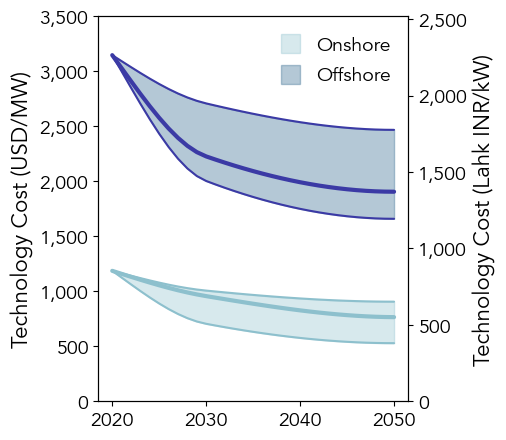

In [326]:
def _plot_wind_cost(ax, df_, 
                    ylabel = r'Technology Cost (USD/MW)',
                    yplabel = r'Technology Cost (Lahk INR/kW)'):

    idx_on_low_  = (df_['scenario'] == 'WDlow') & (df_['technology'] == 'Wind')
    idx_on_mid_  = (df_['scenario'] == 'WDmid') & (df_['technology'] == 'Wind')
    idx_on_high_ = (df_['scenario'] == 'WDhigh') & (df_['technology'] == 'Wind')

    idx_off_low_  = (df_['scenario'] == 'WDlow') & (df_['technology'] == 'Offshore')
    idx_off_mid_  = (df_['scenario'] == 'WDmid') & (df_['technology'] == 'Offshore')
    idx_off_high_ = (df_['scenario'] == 'WDhigh') & (df_['technology'] == 'Offshore')

    ax.plot(df_.loc[idx_on_low_, 'vintage'], df_.loc[idx_on_low_, 'capital_real_cost_per_kw'],
            color = '#8dc0cd', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_on_mid_, 'vintage'], df_.loc[idx_on_mid_, 'capital_real_cost_per_kw'],
            color = '#8dc0cd', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_on_high_, 'vintage'], df_.loc[idx_on_high_, 'capital_real_cost_per_kw'],
            color = '#8dc0cd', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_on_mid_, 'vintage'], 
                    df_.loc[idx_on_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_on_high_, 'capital_real_cost_per_kw'], 
                    color = '#8dc0cd', alpha = 0.35, label = 'Onshore')

    ax.plot(df_.loc[idx_off_low_, 'vintage'], df_.loc[idx_off_low_, 'capital_real_cost_per_kw'],
            color = '#3b3aa5', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_off_mid_, 'vintage'], df_.loc[idx_off_mid_, 'capital_real_cost_per_kw'],
            color = '#3b3aa5', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_off_high_, 'vintage'], df_.loc[idx_off_high_, 'capital_real_cost_per_kw'],
            color = '#3b3aa5', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_off_mid_, 'vintage'], 
                    df_.loc[idx_off_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_off_high_, 'capital_real_cost_per_kw'], 
                    color = '#2a648a', alpha = 0.35, label = 'Offshore')
    
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.legend(loc     = 'upper right',
              frameon = False,
              prop    = {'size': 14})

    ax.set_ylim(0, 3500)
    
    axp = ax.twinx()
    axp.set_ylim(0, 3500*USD_to_INR/1e2)
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_tick_params(labelsize = 14)
    axp.set_ylabel(yplabel, fontsize = 16)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_wind_cost(ax, new_wind_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

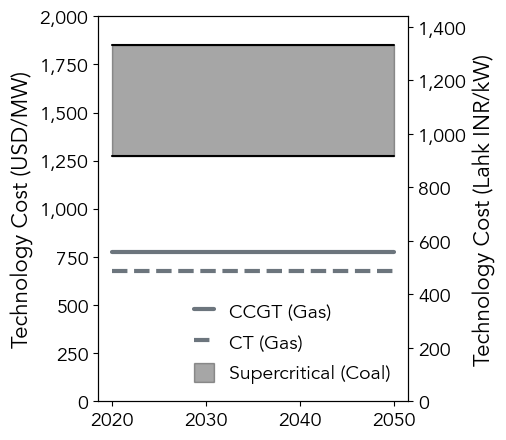

In [317]:
def _plot_convectional_cost(ax, df_,
                            ylabel = r'Technology Cost (USD/MW)',
                            yplabel = r'Technology Cost (Lahk INR/kW)'):
    
    idx_coal_low_  = (df_['scenario'] == 'CONVmid') & (df_['technology'] == 'Supercritical_Coal')
    idx_coal_high_ = (df_['scenario'] == 'CONVhigh') & (df_['technology'] == 'Supercritical_Coal')

    idx_ccgt_  = (df_['scenario'] == 'CONVmid') & (df_['technology'] == 'CCGT')
    idx_ct_ = (df_['scenario'] == 'CONVmid') & (df_['technology'] == 'CT')

    ax.plot(df_.loc[idx_coal_low_, 'vintage'], df_.loc[idx_coal_low_, 'capital_real_cost_per_kw'], 
            color = 'k', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_coal_high_, 'vintage'], df_.loc[idx_coal_high_, 'capital_real_cost_per_kw'], 
            color = 'k', lw = 1.5, solid_capstyle='round')

    ax.plot(df_.loc[idx_ccgt_, 'vintage'], df_.loc[idx_ccgt_, 'capital_real_cost_per_kw'], 
            color = '#6c757d', lw = 3, solid_capstyle='round', label = 'CCGT (Gas)')
    ax.plot(df_.loc[idx_ct_, 'vintage'], df_.loc[idx_ct_, 'capital_real_cost_per_kw'], 
            color = '#6c757d', lw = 3, solid_capstyle='round', ls = '--', label = 'CT (Gas)')
    
    ax.fill_between(df_.loc[idx_coal_low_, 'vintage'], 
                    df_.loc[idx_coal_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_coal_high_, 'capital_real_cost_per_kw'], 
                    color = 'k', alpha = 0.35, label = 'Supercritical (Coal)')
    
    ax.legend(loc     = 'lower right',
              frameon = False,
              ncol    = 1,
              prop    = {'size': 14})
    
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_ylim(0, 2000)

    axp = ax.twinx()
    axp.set_ylim(0, 2000*USD_to_INR/1e2)
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_tick_params(labelsize = 14)
    axp.set_ylabel(yplabel, fontsize = 16)
    
fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_convectional_cost(ax, new_conventional_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

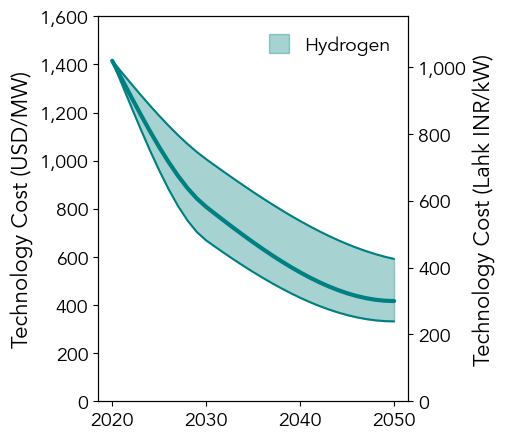

In [318]:
def _plot_hydrogen_power_cost(ax, df_,
                              ylabel  = r'Technology Cost (USD/MW)',
                              yplabel = r'Technology Cost (Lahk INR/kW)'):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kw'], 
            color = 'teal', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kw'], 
            color = 'teal', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kw'], 
            color = 'teal', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kw'], 
                    color = 'teal', alpha = 0.35, label = 'Hydrogen')
    
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.legend(loc     = 'upper right',
              frameon = False,
              prop    = {'size': 14})
    
    ax.set_ylim(0, 1600)
    
    axp = ax.twinx()
    axp.set_ylim(0, 1600*USD_to_INR/1e2)
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_tick_params(labelsize = 14)
    axp.set_ylabel(yplabel, fontsize = 16)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_hydrogen_power_cost(ax, new_hydrogen_cavern_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

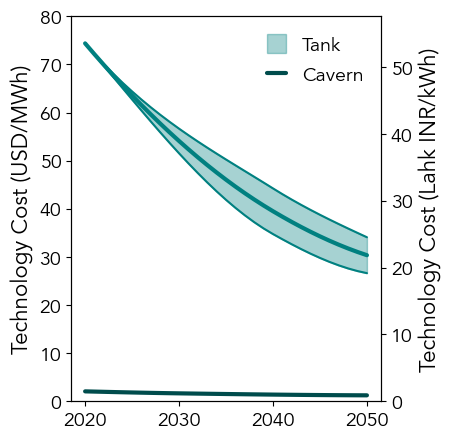

In [320]:
def _plot_hydrogen_energy_cost(ax, df_, df_1_,
                              ylabel  = r'Technology Cost (USD/MWh)',
                              yplabel = r'Technology Cost (Lahk INR/kWh)'):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kwh'], 
            color = 'teal', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kwh'], 
            color = 'teal', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
            color = 'teal', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kwh'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
                    color = 'teal', alpha = 0.35, label = 'Tank')
    
    idx_low_  = df_1_['scenario'] == 'STlow'
    idx_mid_  = df_1_['scenario'] == 'STmid'
    idx_high_ = df_1_['scenario'] == 'SThigh'
    
    # ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kwh'], 
    #         color = 'teal', lw = 1.5)
    ax.plot(df_1_.loc[idx_mid_, 'vintage'], df_1_.loc[idx_mid_, 'capital_real_cost_per_kwh'], 
            color = '#004c4c',  lw = 3, label = 'Cavern', solid_capstyle='round')
    # ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
    #         color = 'teal', lw = 1.5)
    
    # ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
    #                 df_.loc[idx_low_, 'capital_real_cost_per_kwh'],
    #                 df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
    #                 color = 'teal', alpha = 0.35, label = 'Hydrogen')
    
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.legend(loc     = 'upper right',
              frameon = False,
              prop    = {'size': 14})
    
    ax.set_ylim(0, 80)
    
    axp = ax.twinx()
    axp.set_ylim(0, 80*USD_to_INR/1e2)
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_tick_params(labelsize = 14)
    axp.set_ylabel(yplabel, fontsize = 16)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_hydrogen_energy_cost(ax, new_hydrogen_tank_costs_all, new_hydrogen_cavern_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

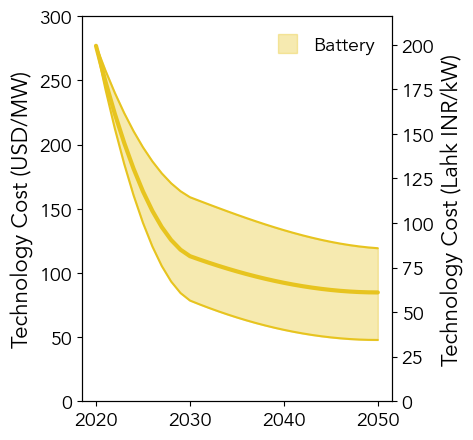

In [321]:
def _plot_battery_power_cost(ax, df_, 
                             ylabel  = r'Technology Cost (USD/MW)', 
                             yplabel = r'Technology Cost (Lahk INR/kW)'):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kw'], 
            color = '#e7c41f', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kw'],
            color = '#e7c41f', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kw'],
            color = '#e7c41f', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kw'], 
                    color = '#e7c41f', alpha = 0.35, label = 'Battery')
    
    ax.legend(loc     = 'upper right',
              frameon = False,
              prop    = {'size': 14})
    
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(ylabel, fontsize = 16)
    
    ax.set_ylim(0, 300)
    
    axp = ax.twinx()
    axp.set_ylim(0, 300*USD_to_INR/1e2)
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_tick_params(labelsize = 14)
    axp.set_ylabel(yplabel, fontsize = 16)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_battery_power_cost(ax, new_battery_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

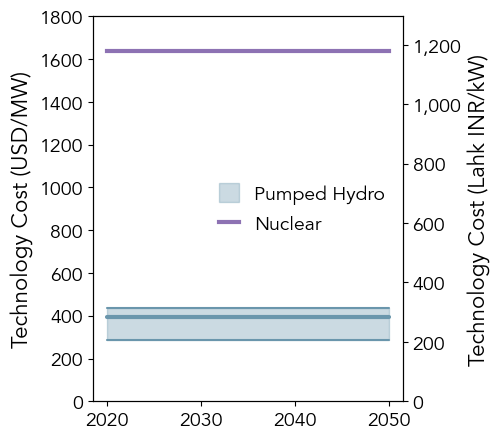

In [322]:
def _plot_phs_power_cost(ax, df_, df_1_,
                             ylabel  = r'Technology Cost (USD/MW)', 
                             yplabel = r'Technology Cost (Lahk INR/kW)'):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kw'], 
            color = '#6a96ac', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kw'],
            color = '#6a96ac', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kw'],
            color = '#6a96ac', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kw'], 
                    color = '#6a96ac', alpha = 0.35, label = 'Pumped Hydro')
    
    idx_nuclear_ = (df_1_['scenario'] == 'NUCLmid') & (df_1_['technology'] == 'Nuclear')

    ax.plot(df_1_.loc[idx_nuclear_, 'vintage'], df_1_.loc[idx_nuclear_, 'capital_real_cost_per_kw'], 
            color = '#8d72b3', lw = 3, label = 'Nuclear')
    
    ax.legend(loc     = 'center right',
              frameon = False,
              prop    = {'size': 14})
    
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(ylabel, fontsize = 16)
    
    ax.set_ylim(0, 1800)
    
    axp = ax.twinx()
    axp.set_ylim(0, 1800*USD_to_INR/1e2)
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_tick_params(labelsize = 14)
    axp.set_ylabel(yplabel, fontsize = 16)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_phs_power_cost(ax, new_hydro_costs_all, new_nuclear_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

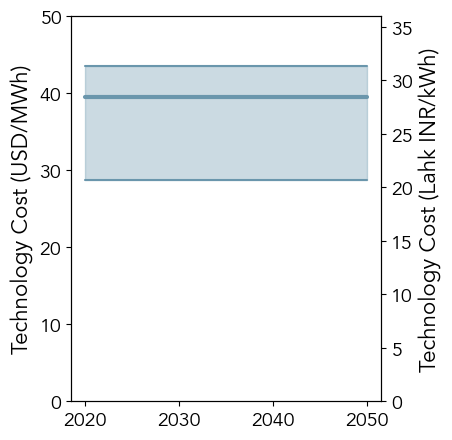

In [323]:
def _plot_phs_energy_cost(ax, df_, 
                             ylabel  = r'Technology Cost (USD/MWh)', 
                             yplabel = r'Technology Cost (Lahk INR/kWh)'):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kwh'], 
            color = '#6a96ac', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kwh'],
            color = '#6a96ac', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kwh'],
            color = '#6a96ac', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kwh'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
                    color = '#6a96ac', alpha = 0.35, label = 'Pumped Hydro')
    
    # ax.legend(loc     = 'upper right',
    #           frameon = False,
    #           prop    = {'size': 14})
    
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(ylabel, fontsize = 16)
    
    ax.set_ylim(0, 50)
    
    axp = ax.twinx()
    axp.set_ylim(0, 50*USD_to_INR/1e2)
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_tick_params(labelsize = 14)
    axp.set_ylabel(yplabel, fontsize = 16)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_phs_energy_cost(ax, new_hydro_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

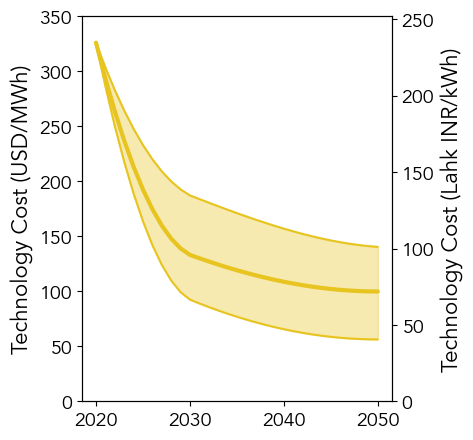

In [324]:
def _plot_battery_energy_cost(ax, df_, 
                                ylabel  = r'Technology Cost (USD/MWh)', 
                                yplabel = r'Technology Cost (Lahk INR/kWh)'):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kwh'], 
            color = '#e7c41f', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kwh'],
            color = '#e7c41f', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kwh'],
            color = '#e7c41f', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kwh'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
                    color = '#e7c41f', alpha = 0.35, label = 'Battery')
    
#     ax.legend(loc     = 'upper right',
#               frameon = False,
#               prop    = {'size': 14})
    
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(ylabel, fontsize = 16)
    
    ax.set_ylim(0, 350)
    
    axp = ax.twinx()
    axp.set_ylim(0, 350*USD_to_INR/1e2)
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_tick_params(labelsize = 14)
    axp.set_ylabel(yplabel, fontsize = 16)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_battery_energy_cost(ax, new_battery_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

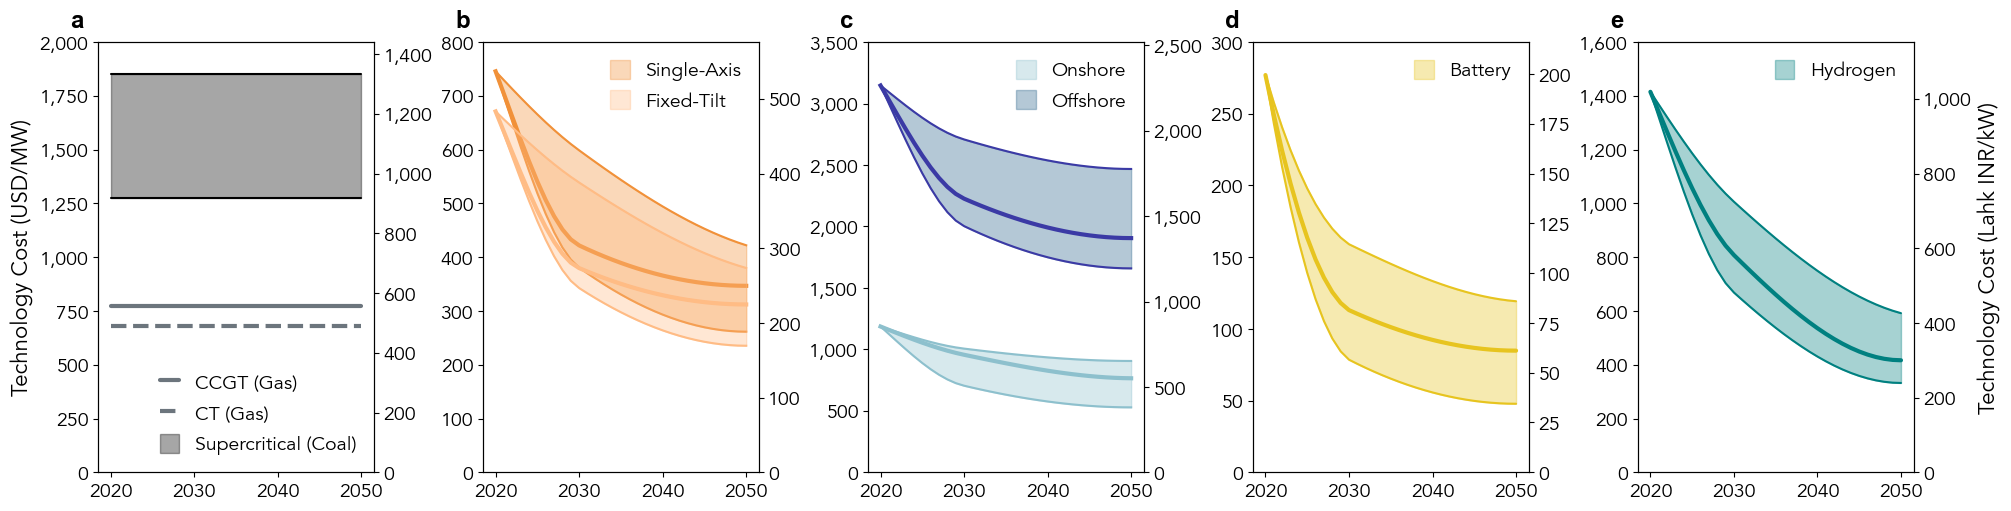

In [325]:
fig, _ax = plt.subplot_mosaic([['a', 'b', 'c', 'd', 'e']],
                              layout      = 'constrained', 
                              figsize     = (20, 5), 
                              gridspec_kw = {'width_ratios': [1, 1, 1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans),
            fontsize  = 'xx-large', 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')
    
_plot_convectional_cost(_ax['a'], new_conventional_costs_all, yplabel = '')

_plot_solar_cost(_ax['b'], new_solar_costs_all, ylabel = '', yplabel = '')

_plot_wind_cost(_ax['c'], new_wind_costs_all, ylabel = '', yplabel = '')

_plot_battery_power_cost(_ax['d'], new_battery_costs_all, ylabel = '', yplabel = '')
_plot_hydrogen_power_cost(_ax['e'], new_hydrogen_cavern_costs_all, ylabel = '')

# plt.savefig(path_to_images + f'/demand_profiles-{method}.pdf', 
#             bbox_inches = 'tight', 
#             dpi         = 600)

plt.savefig(path_to_images + f'/technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

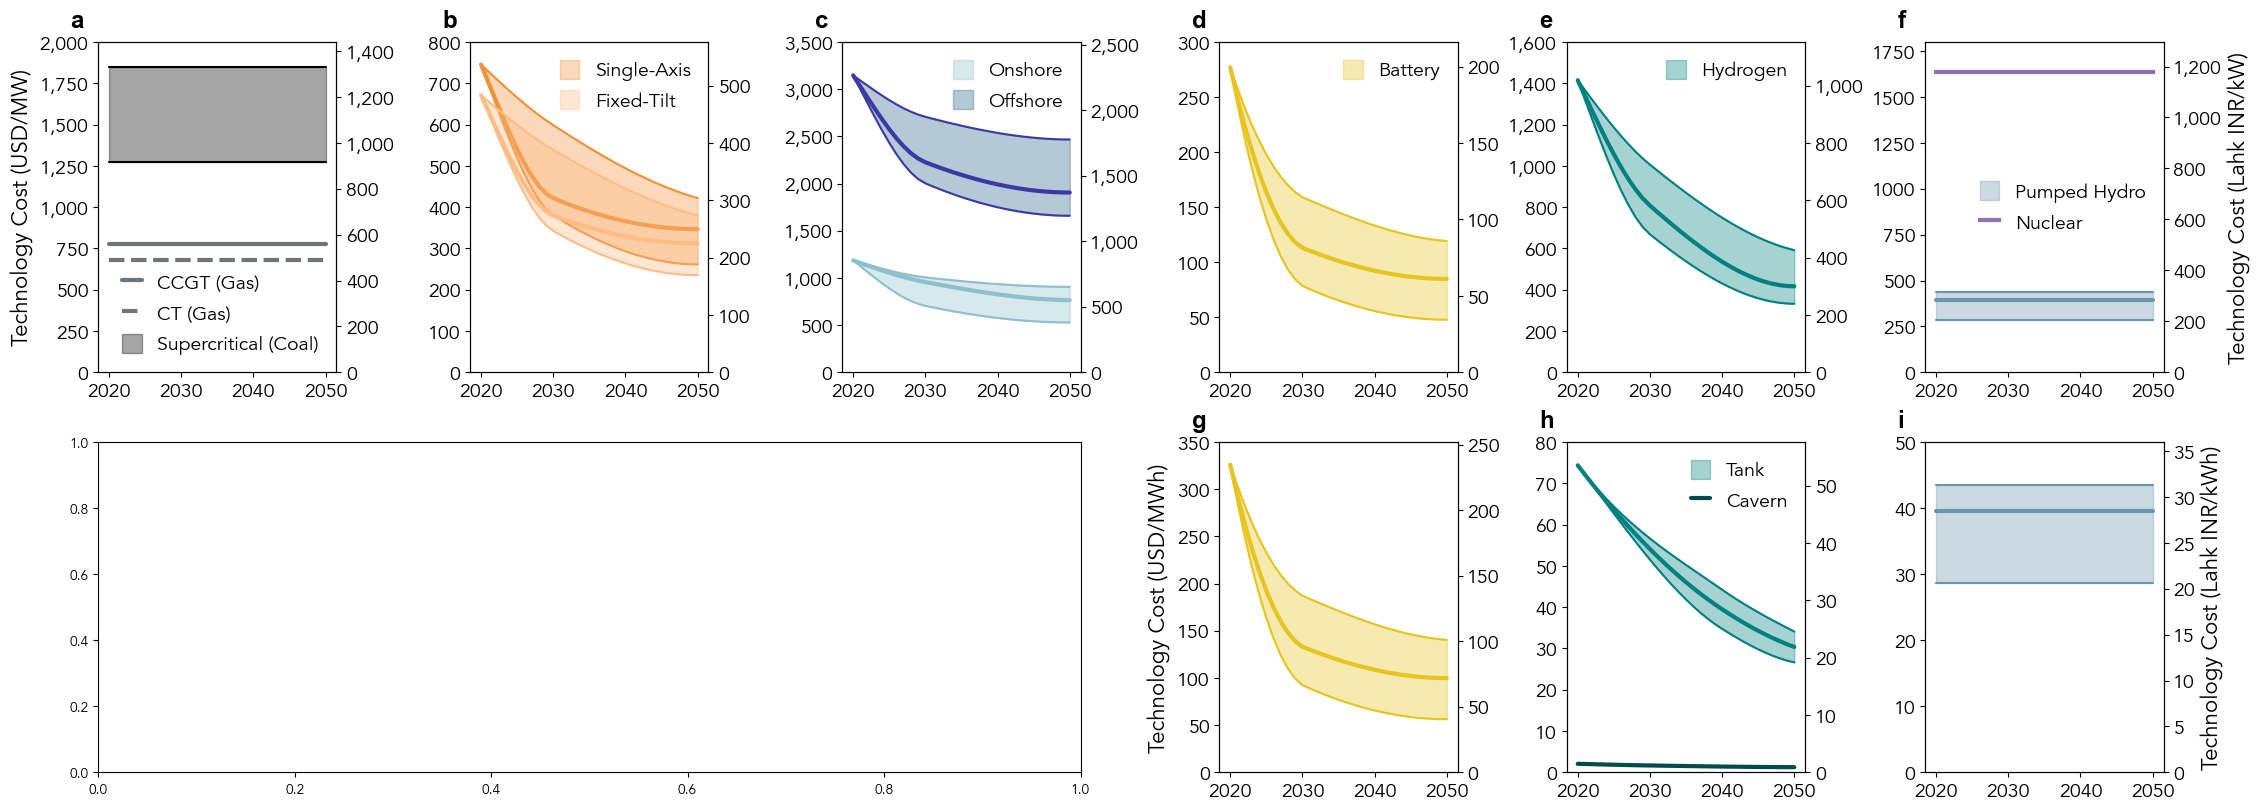

In [328]:
fig, _ax = plt.subplot_mosaic([['a', 'b', 'c', 'd', 'e', 'f'],
                               [' ', ' ', ' ', 'g', 'h', 'i']],
                              layout      = 'constrained', 
                              figsize     = (22.5, 8), 
                              gridspec_kw = {'width_ratios': [1, 1, 1, 1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans),
            fontsize  = 'xx-large', 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')
    
_plot_convectional_cost(_ax['a'], new_conventional_costs_all, yplabel = '')

_plot_solar_cost(_ax['b'], new_solar_costs_all, ylabel = '', yplabel = '')

_plot_wind_cost(_ax['c'], new_wind_costs_all, ylabel = '', yplabel = '')

_plot_battery_power_cost(_ax['d'], new_battery_costs_all, ylabel = '', yplabel = '')
_plot_hydrogen_power_cost(_ax['e'], new_hydrogen_cavern_costs_all, ylabel = '', yplabel = '')

_plot_phs_power_cost(_ax['f'], new_hydro_costs_all, new_nuclear_costs_all, ylabel = '')


_plot_battery_energy_cost(_ax['g'], new_battery_costs_all, yplabel = '')

_plot_hydrogen_energy_cost(_ax['h'], new_hydrogen_tank_costs_all, new_hydrogen_cavern_costs_all, ylabel = '', yplabel = '')

_plot_phs_energy_cost(_ax['i'], new_hydro_costs_all, ylabel = '')


# plt.savefig(path_to_images + f'/demand_profiles-{method}.pdf', 
#             bbox_inches = 'tight', 
#             dpi         = 600)

plt.savefig(path_to_images + f'/technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [80]:
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv')
print(tech_labels_)

                  group              technology group_color    color  order
0                  Coal  Subcritical_Coal_Large     #343a40  #343a40      1
1                  Coal  Subcritical_Coal_Small     #343a40  #343a40      1
2                  Coal      Supercritical_Coal     #343a40  #343a40      1
3                   Gas                    CCGT     #6c757d  #6c757d      2
4                   Gas                      CT     #6c757d  #6c757d      2
5                Diesel                  Diesel     #924B00  #924B00      3
6                 Hydro               Hydro_ROR     #2a648a  #2a648a      6
7                 Hydro           Hydro_Storage     #2a648a  #2a648a      6
8                 Other                 Biomass     #6ba661  #6a96ac      5
9                 Other                     WHR     #6ba661  #6ba661      5
10             Hydrogen                Hydrogen        teal     teal     11
11              Battery                 Battery     #e7c41f  #e7c41f     10
12          

In [337]:
def _group_capacity_technologies(capacity_, tech_labels_):

    for group in tech_labels_['group'].unique():
        capacity_.loc[capacity_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
       
    capacity_.loc[capacity_['technology'] == 'Pumped Storage', 'technology'] = 'Hydro'
    capacity_ = capacity_.groupby(['technology', 
                                   'load_zone']).agg({'capacity_mw': 'sum'})

    return capacity_.reset_index(drop = False)

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios/demand/VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid/inputs/'

tx_                   = pd.read_csv(path_to_scenarios + 'specified_transmission_line_capacities.tab', sep = '\t')
tx_['load_zone_from'] = tx_['transmission_line'].apply(lambda x: x.split('-')[0])
tx_['load_zone_to']   = tx_['transmission_line'].apply(lambda x: x.split('-')[1])
tx_                   = tx_.loc[tx_['period'] == 2020].reset_index(drop = True)
tx_                   = tx_[['specified_tx_max_mw', 'load_zone_from', 'load_zone_to']]
tx_                   = tx_.rename(columns = {'specified_tx_max_mw': 'tx_mw'})

cap_ = pd.read_csv(path_to_scenarios + 'spec_capacity_period_params.tab', sep = '\t')
cap_ = cap_.loc[cap_['period'] == 2020].reset_index(drop = True)
cap_ = cap_[['project', 'specified_capacity_mw']].set_index('project')

proj_ = pd.read_csv(path_to_scenarios + 'projects.tab', sep = '\t')
proj_ = proj_[['project', 'technology', 'load_zone']].set_index('project')

cap_['technology'] = proj_.loc[cap_.index, ['technology']]
cap_['load_zone']  = proj_.loc[cap_.index, ['load_zone']]
cap_               = cap_.reset_index(drop = True)
cap_               = cap_.rename(columns = {'specified_capacity_mw': 'capacity_mw'})
cap_               = cap_.groupby(['capacity_mw', 'technology', 'load_zone']).agg('sum').reset_index(drop = False)
#print(cap_)

group_cap_ = _group_capacity_technologies(cap_, tech_labels_)
total_cap_ = group_cap_[['load_zone', 'capacity_mw']].groupby(['load_zone']).agg('sum').reset_index(drop = False)
print(group_cap_['technology'].unique())



['Coal' 'Diesel' 'Gas' 'Hydro' 'Nuclear' 'Other' 'Solar' 'Wind']


In [357]:
def _opt_dist(x_, y_, d = 1.35, delta = 0.1):
    
    def __update_position(x, x_0, z):
        return x + ((x - x_0)/z)*delta, x_0 + ((x_0 - x)/z)*delta  
    
    while True:
        flag = True
        for i in range(x_.shape[0]):
            for j in range(x_.shape[0]):
                if i != j:
                    z = np.sqrt( (x_[j] - x_[i])**2 + (y_[j] - y_[i])**2 )
                    if z < d:
                        x_[j], x_[i] = __update_position(x_[j], x_[i], z)
                        y_[j], y_[i] = __update_position(y_[j], y_[i], z)
                        flag = False
        if flag:
            break

    return x_, y_


_map = gpd.read_file(path_to_data + r"map/india-polygon.shp").to_crs("epsg:4326")
#_map = _map.drop([0, 15])

_nothern      = _map.loc[[4, 10, 11, 22, 24, 25, 30, 31, 35, 36]].dissolve().buffer(.025)#.to_crs(epsg=3395).to_crs("epsg:4326")
_northeastern = _map.loc[[1, 2, 18, 19, 20, 21, 29]].dissolve()
_western      = _map.loc[[5, 6, 7, 8, 9, 16, 17]].dissolve()
_southern     = _map.loc[[13, 14, 23, 27, 28, 34]].dissolve()
_eastern      = _map.loc[[3, 12, 26, 32, 33]].dissolve()
_regions      = pd.concat([_northeastern, _western, _southern, _eastern], axis = 0)

city_ = pd.read_csv(path_to_input + r"transmission/major_cities_india.csv")
city_ = city_.drop(columns = ['state', 'major_city'])
city_ = city_.rename(columns = {'acronym': 'load_zone_abr'})
city_ = city_.drop([28, 34, 35]).reset_index(drop = True)

load_zones_ = pd.read_csv(path_to_input + r"/india_zones.csv")
load_zones_ = load_zones_.drop(columns = ['state', 'rps_zone'])

load_zones_ = load_zones_.drop([3, 35, 36]).reset_index(drop = True)
load_zones_ = pd.merge(city_, load_zones_, on  = 'load_zone_abr', 
                                           how = 'inner')

load_zones_p_ = load_zones_.copy()

load_zones_p_['longitude'], load_zones_p_['latitude'] = _opt_dist(load_zones_p_['longitude'].to_numpy(), 
                                                                  load_zones_p_['latitude'].to_numpy())

total_cap_['capacity_gw'] = (total_cap_['capacity_mw']/1000.).round(2)
total_cap_['position'] = 1

total_cap_.loc[15, 'position'] = 0
total_cap_.loc[7, 'position']  = 0
total_cap_.loc[25, 'position'] = 0
total_cap_.loc[4, 'position']  = 2
total_cap_.loc[14, 'position'] = 0
total_cap_.loc[27, 'position'] = 0
total_cap_.loc[20, 'position'] = 0
total_cap_.loc[30, 'position'] = 0
total_cap_.loc[2, 'position']  = 0
total_cap_.loc[10, 'position'] = 0
total_cap_.loc[26, 'position'] = 0

load_zones_p_.loc[30, 'longitude'] += .15
load_zones_p_.loc[29, 'longitude'] -= .4

/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_46672/1337525157.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  _nothern      = _map.loc[[4, 10, 11, 22, 24, 25, 30, 31, 35, 36]].dissolve().buffer(.025)#.to_crs(epsg=3395).to_crs("epsg:4326")


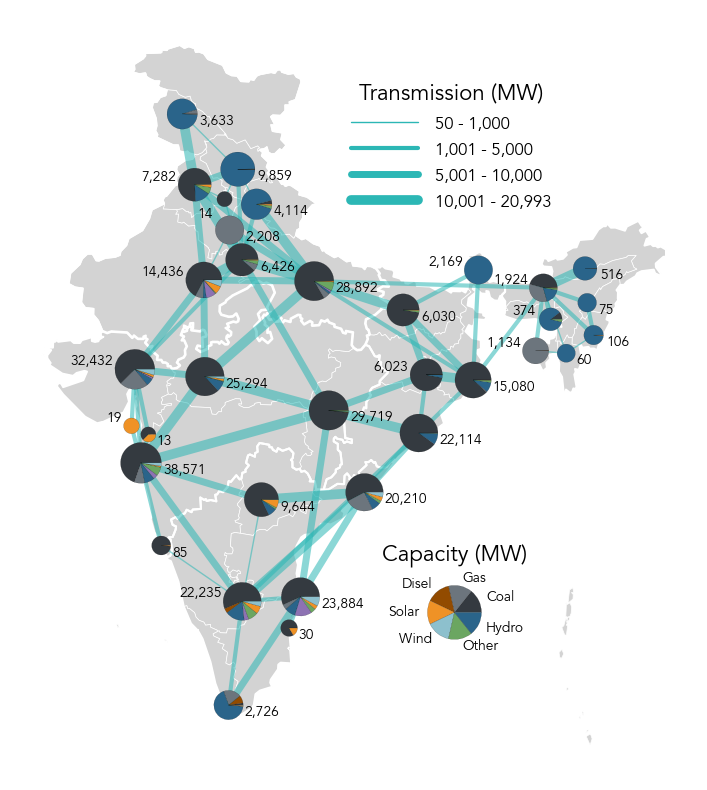

In [358]:
def _plot_specified_capacity(ax, tx_, group_cap_, total_cap_, load_zones_):

               
    for i in range(tx_.shape[0]):

        load_zone_to_   = load_zones_.loc[load_zones_['load_zone'] == tx_.loc[i, 'load_zone_to']]
        load_zone_from_ = load_zones_.loc[load_zones_['load_zone'] == tx_.loc[i, 'load_zone_from']]

        x_ = np.concatenate([load_zone_from_['latitude'].to_numpy(), load_zone_to_['latitude'].to_numpy()], axis = 0)
        y_ = np.concatenate([load_zone_from_['longitude'].to_numpy(), load_zone_to_['longitude'].to_numpy()], axis = 0)

        #z = np.sqrt(np.absolute(tx_.loc[i, 'tx_mw'])/1e3)

        if tx_.loc[i, 'tx_mw'] < 1000.:
            ax.plot(y_, x_, lw             = 1., 
                            zorder         = 10, 
                            color          = '#2cb7b5', 
                            solid_capstyle ='round', 
                            alpha          = .55)

        if (tx_.loc[i, 'tx_mw'] < 5000.) & (tx_.loc[i, 'tx_mw'] >= 1000.):
            ax.plot(y_, x_, lw             = 3, 
                            zorder         = 10, 
                            color          = '#2cb7b5', 
                            solid_capstyle ='round', 
                            alpha          = .55)

        if (tx_.loc[i, 'tx_mw'] < 10000.) & (tx_.loc[i, 'tx_mw'] >= 5000.):
            ax.plot(y_, x_, lw             = 5, 
                            zorder         = 10, 
                            color          = '#2cb7b5', 
                            solid_capstyle ='round', 
                            alpha          = .55)

        if tx_.loc[i, 'tx_mw'] >= 10000.:
            ax.plot(y_, x_, lw             = 7, 
                            zorder         = 10, 
                            color          = '#2cb7b5', 
                            solid_capstyle ='round', 
                            alpha          = .55)


    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    for i in range(total_cap_.shape[0]):

        load_zone_ = load_zones_.loc[load_zones_['load_zone'] == total_cap_.loc[i, 'load_zone']]
        cap_ = group_cap_.loc[group_cap_['load_zone'] == total_cap_.loc[i, 'load_zone'], ['technology', 'capacity_mw']]

        total = total_cap_.loc[i, 'capacity_mw']
        #totalp = total_cap_.loc[i, 'capacity_gw']
        totalp = int(total)

        width = np.sqrt(np.sqrt(np.sqrt(total/1e3)))/3.1

        axp_ = inset_axes(ax, width          = width, 
                              height         = width, 
                              bbox_to_anchor = (load_zone_['longitude'], load_zone_['latitude']),
                              loc            = 10, 
                              bbox_transform = ax.transData, 
                              borderpad      = 0)
        
        x = 0
        if len(str(totalp)) < 3:
            x = -4
        if len(str(totalp)) > 3:
            x = 2
        if len(str(totalp)) > 4:
            x = 4
            
        if total_cap_.loc[i, 'position'] == 0:
            axp_.set_ylabel(f'{totalp:,}', fontsize = 10, labelpad = 9 + x, rotation = 0)
        if total_cap_.loc[i, 'position'] == 1:
            axp_.set_ylabel(f'{totalp:,}', fontsize = 10, labelpad = 9 + x, rotation = 0)
            axp_.yaxis.set_label_position('right') 
        if total_cap_.loc[i, 'position'] == 2:
            axp_.set_xlabel(f'{totalp:,}', fontsize = 10, labelpad = -1.5, x = -.5)
        if total_cap_.loc[i, 'position'] == 3:
            axp_.set_xlabel(f'{totalp:,}', fontsize = 10, labelpad = -1.5)
            axp_.xaxis.set_label_position('top') 

        axp_.pie(cap_['capacity_mw']/total,
                 wedgeprops = {'edgecolor': 'black', 'linewidth': .1}, 
                 colors     = [tech_labels_.loc[tech_labels_['group'] == tech, 'group_color'].to_numpy()[0] for tech in cap_['technology']])

    _nothern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _northeastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _western.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _southern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _eastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _map.plot(ax = ax, zorder = 8, color = 'lightgray', lw = 0.5, edgecolor = 'white')

    axp_ = inset_axes(ax, width          = .675, 
                          height         = .675, 
                          bbox_to_anchor = (87.5, 12.5),
                          loc            = 10, 
                          bbox_transform = ax.transData, 
                          borderpad      = 0)

    axp_.set_title('Capacity (MW)', size = 16, y = 1.125)
    axp_.pie([1, 1, 1, 1, 1, 1, 1], 
             wedgeprops    = {'edgecolor': 'black', 'linewidth': .1},
             colors        = ['#343a40', '#6c757d', '#924B00', '#ef9226', '#8dc0cd', '#6ba661', '#2a648a'],
             labels        = ['Coal', 'Gas', 'Disel', 'Solar', 'Wind', 'Other', 'Hydro'], 
             labeldistance = 1.3)
    # #95cca3 #2cb7b5
    line1 = Line2D([], [], color = '#2cb7b5', lw = 1, solid_capstyle ='round')
    line2 = Line2D([], [], color = '#2cb7b5', lw = 3, solid_capstyle ='round')
    line3 = Line2D([], [], color = '#2cb7b5', lw = 5, solid_capstyle ='round')
    line4 = Line2D([], [], color = '#2cb7b5', lw = 7, solid_capstyle ='round')

    ax.legend((line1, line2, line3, line4), ('50 - 1,000', '1,001 - 5,000', '5,001 - 10,000', '10,001 - 20,993'), 
               title_fontsize = 16,
               title          = 'Transmission (MW)',
               handlelength   = 4.,
               handletextpad  = 1.,
               labelspacing   = .5,
               frameon        = False, 
               bbox_to_anchor = (0.475, 0.925), 
               prop           = {'size': 12})

    # ax2 = ax.twinx()
    # ax2.bar(0., 0., 0., color  = '#343a40',
    #                    label  = 'Coal')

    # ax2.bar(0., 0., 0., color  = '#6c757d',
    #                    label  = 'Gas')

    # ax2.bar(0., 0., 0., color  = '#924B00',
    #                    label  = 'Diesel')

    # ax2.bar(0., 0., 0., color  = '#ef9226',
    #                    label  = 'Solar')

    # ax2.bar(0., 0., 0., color  = '#8dc0cd',
    #                    label  = 'Wind')

    # ax2.bar(0., 0., 0., color  = '#6ba661',
    #                    label  = 'Other')

    # ax2.bar(0., 0., 0., color  = '#2a648a',
    #                    label  = 'Hydro')

    # ax2.legend(loc            = 'center left',
    #            title          = 'Resource',
    #            title_fontsize = 16,
    #            bbox_to_anchor = (.8, 0.125),
    #            frameon        = False,
    #            prop           = {'size': 12})
    # ax2.axis('off')

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

_plot_specified_capacity(ax, tx_, group_cap_, total_cap_, load_zones_p_)

plt.savefig(path_to_images + '/existing_capacity.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()